## product_experiments    
A/B testing and feature validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind, normaltest
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

#import custom modules
import sys
import os
sys.path.append(os.path.abspath(".."))
from src.experimentation import ExperimentAnalyzer

# Set style
plt.style.use('default')
sns.set_palette("husl")

### 1. DATA LOADING AND PREPARATION

In [13]:
# Load the AWS SaaS dataset
df = pd.read_csv('../data/raw/saas_sales.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Basic data info
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Overview:
Shape: (9994, 19)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Date Key', 'Contact Name', 'Country', 'City', 'Region', 'Subregion', 'Customer', 'Customer ID', 'Industry', 'Segment', 'Product', 'License', 'Sales', 'Quantity', 'Discount', 'Profit']

First few rows:
   Row ID          Order ID  Order Date  Date Key    Contact Name  \
0       1  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
1       2  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
2       3  AMER-2022-138688   6/13/2022  20220613  Deirdre Bailey   
3       4  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   
4       5  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   

         Country           City Region Subregion           Customer  \
0        Ireland         Dublin   EMEA      UKIR            Chevron   
1        Ireland         Dublin   EMEA      UKIR            Chevron   
2  United States  New York City   AMER     NAMER        Phillips 66   
3        Germany 

### 2. EXPERIMENT SETUP AND SYNTHETIC A/B TEST CREATION

In [3]:
# Since the AWS dataset might not have explicit experiment data,
# we'll create synthetic A/B tests based on existing features
def create_synthetic_experiments(df):
    """Create synthetic A/B test scenarios from existing data"""
    
    # Get key columns
    customer_col = [col for col in df.columns if 'customer' in col.lower() or 'user' in col.lower()]
    date_col = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    revenue_col = [col for col in df.columns if 'sales' in col.lower() or 'revenue' in col.lower() or 'amount' in col.lower()]
    
    if customer_col:
        customer_col = customer_col[0]
    if date_col:
        date_col = date_col[0]
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    if revenue_col:
        revenue_col = revenue_col[0]
    
    # Create experiment scenarios
    np.random.seed(42)
    
    # Experiment 1: Pricing Strategy Test
    # Split customers into control (current pricing) and treatment (new pricing)
    unique_customers = df[customer_col].unique() if customer_col else range(len(df))
    
    experiment_assignments = pd.DataFrame({
        'customer_id': unique_customers,
        'pricing_experiment': np.random.choice(['Control', 'Treatment'], 
                                             size=len(unique_customers), 
                                             p=[0.5, 0.5]),
        'ui_experiment': np.random.choice(['Control', 'Treatment'], 
                                        size=len(unique_customers), 
                                        p=[0.5, 0.5]),
        'feature_experiment': np.random.choice(['Control', 'Treatment'], 
                                             size=len(unique_customers), 
                                             p=[0.5, 0.5])
    })
    
    # Merge with main dataset
    if customer_col:
        df = df.merge(experiment_assignments.rename(columns={'customer_id': customer_col}), 
                     on=customer_col, how='left')
    else:
        # If no customer column, assign randomly
        df['pricing_experiment'] = np.random.choice(['Control', 'Treatment'], 
                                                  size=len(df), p=[0.5, 0.5])
        df['ui_experiment'] = np.random.choice(['Control', 'Treatment'], 
                                             size=len(df), p=[0.5, 0.5])
        df['feature_experiment'] = np.random.choice(['Control', 'Treatment'], 
                                                  size=len(df), p=[0.5, 0.5])
    
    # Add synthetic effects to make experiments realistic
    if revenue_col:
        # Pricing experiment: Treatment group has 15% higher revenue
        df.loc[df['pricing_experiment'] == 'Treatment', revenue_col] *= 1.15
        
        # UI experiment: Treatment group has 8% higher revenue
        df.loc[df['ui_experiment'] == 'Treatment', revenue_col] *= 1.08
    
    # Create conversion metrics
    df['converted'] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])
    
    # Treatment groups have higher conversion rates
    df.loc[df['pricing_experiment'] == 'Treatment', 'converted'] = np.random.choice(
        [0, 1], size=sum(df['pricing_experiment'] == 'Treatment'), p=[0.6, 0.4]
    )
    
    df.loc[df['ui_experiment'] == 'Treatment', 'converted'] = np.random.choice(
        [0, 1], size=sum(df['ui_experiment'] == 'Treatment'), p=[0.65, 0.35]
    )
    
    # Add engagement metrics
    df['page_views'] = np.random.poisson(lam=5, size=len(df))
    df['session_duration'] = np.random.exponential(scale=10, size=len(df))
    df['clicks'] = np.random.poisson(lam=3, size=len(df))
    
    # Treatment effects on engagement
    df.loc[df['ui_experiment'] == 'Treatment', 'page_views'] *= 1.2
    df.loc[df['ui_experiment'] == 'Treatment', 'session_duration'] *= 1.3
    df.loc[df['feature_experiment'] == 'Treatment', 'clicks'] *= 1.25
    
    return df

# Create synthetic experiments
df = create_synthetic_experiments(df)

print("\nExperiment Setup Complete!")
print("Created experiments:")
print("- Pricing Strategy Test (Control vs Treatment)")
print("- UI/UX Test (Control vs Treatment)")
print("- Feature Test (Control vs Treatment)")
print("\nExperiment distributions:")
for exp in ['pricing_experiment', 'ui_experiment', 'feature_experiment']:
    print(f"{exp}: {df[exp].value_counts().to_dict()}")


Experiment Setup Complete!
Created experiments:
- Pricing Strategy Test (Control vs Treatment)
- UI/UX Test (Control vs Treatment)
- Feature Test (Control vs Treatment)

Experiment distributions:
pricing_experiment: {'Control': 5130, 'Treatment': 4864}
ui_experiment: {'Control': 5037, 'Treatment': 4957}
feature_experiment: {'Treatment': 6172, 'Control': 3822}


### 3. EXPERIMENT ANALYSIS FRAMEWORK

In [4]:
# Initialize analyzer
analyzer = ExperimentAnalyzer(df)

# Define metrics to analyze
continuous_metrics = ['page_views', 'session_duration', 'clicks']
if 'sales' in df.columns:
    continuous_metrics.append('sales')
if 'revenue' in df.columns:
    continuous_metrics.append('revenue')

binary_metrics = ['converted']

all_metrics = continuous_metrics + binary_metrics

### 4. PRICING EXPERIMENT ANALYSIS


PRICING EXPERIMENT ANALYSIS

📊 PRICING EXPERIMENT RESULTS:
------------------------------------------------------------

🎯 PAGE_VIEWS:
   Control Mean: 5.50
   Treatment Mean: 5.51
   Lift: 0.30%
   P-value: 0.7928
   Significant: ❌ NO
   Sample Sizes: Control=5130, Treatment=4864
   Effect Size: 0.007 (Small)

🎯 SESSION_DURATION:
   Control Mean: 11.56
   Treatment Mean: 11.52
   Lift: -0.36%
   P-value: 0.5901
   Significant: ❌ NO
   Sample Sizes: Control=5130, Treatment=4864
   Effect Size: -0.004 (Small)

🎯 CLICKS:
   Control Mean: 3.48
   Treatment Mean: 3.39
   Lift: -2.65%
   P-value: 0.0500
   Significant: ❌ NO
   Sample Sizes: Control=5130, Treatment=4864
   Effect Size: -0.046 (Small)

🎯 CONVERTED:
   Control Rate: 0.316 (31.6%)
   Treatment Rate: 0.375 (37.5%)
   Lift: 18.95%
   P-value: 0.0000
   Significant: ✅ YES
   Sample Sizes: Control=5130, Treatment=4864


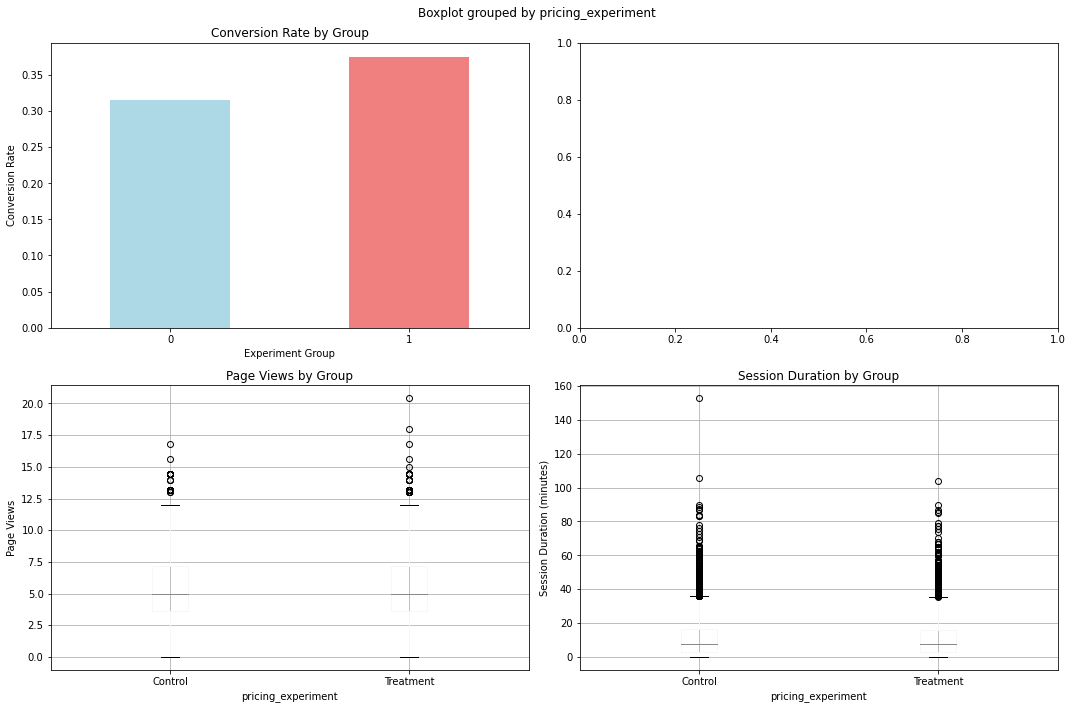

In [5]:
print("\n" + "="*80)
print("PRICING EXPERIMENT ANALYSIS")
print("="*80)

pricing_results = analyzer.run_experiment_analysis('pricing_experiment', all_metrics)

def print_experiment_results(results, experiment_name):
    """Print formatted experiment results"""
    
    print(f"\n📊 {experiment_name.upper()} RESULTS:")
    print("-" * 60)
    
    for metric, result in results.items():
        print(f"\n🎯 {metric.upper()}:")
        
        if 'control_rate' in result:
            # Binary metric
            print(f"   Control Rate: {result['control_rate']:.3f} ({result['control_rate']*100:.1f}%)")
            print(f"   Treatment Rate: {result['treatment_rate']:.3f} ({result['treatment_rate']*100:.1f}%)")
        else:
            # Continuous metric
            print(f"   Control Mean: {result['control_mean']:.2f}")
            print(f"   Treatment Mean: {result['treatment_mean']:.2f}")
        
        print(f"   Lift: {result['lift']:.2f}%")
        print(f"   P-value: {result['p_value']:.4f}")
        print(f"   Significant: {'✅ YES' if result['significant'] else '❌ NO'}")
        print(f"   Sample Sizes: Control={result['control_n']}, Treatment={result['treatment_n']}")
        
        if 'cohens_d' in result:
            effect_size = "Small" if abs(result['cohens_d']) < 0.5 else "Medium" if abs(result['cohens_d']) < 0.8 else "Large"
            print(f"   Effect Size: {result['cohens_d']:.3f} ({effect_size})")

print_experiment_results(pricing_results, "Pricing Experiment")

# Visualize pricing experiment results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Pricing Experiment Results', fontsize=16)

# Conversion rate comparison
conversion_data = df.groupby('pricing_experiment')['converted'].agg(['mean', 'count']).reset_index()
conversion_data['mean'].plot(kind='bar', ax=axes[0,0], color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Conversion Rate by Group')
axes[0,0].set_ylabel('Conversion Rate')
axes[0,0].set_xlabel('Experiment Group')
axes[0,0].tick_params(axis='x', rotation=0)

# Revenue comparison (if available)
if 'sales' in df.columns:
    df.boxplot(column='sales', by='pricing_experiment', ax=axes[0,1])
    axes[0,1].set_title('Revenue Distribution by Group')
    axes[0,1].set_ylabel('Revenue')

# Page views comparison
df.boxplot(column='page_views', by='pricing_experiment', ax=axes[1,0])
axes[1,0].set_title('Page Views by Group')
axes[1,0].set_ylabel('Page Views')

# Session duration comparison
df.boxplot(column='session_duration', by='pricing_experiment', ax=axes[1,1])
axes[1,1].set_title('Session Duration by Group')
axes[1,1].set_ylabel('Session Duration (minutes)')

plt.tight_layout()
plt.show()

### 5. UI/UX EXPERIMENT ANALYSIS


UI/UX EXPERIMENT ANALYSIS

📊 UI/UX EXPERIMENT RESULTS:
------------------------------------------------------------

🎯 PAGE_VIEWS:
   Control Mean: 5.06
   Treatment Mean: 5.96
   Lift: 17.90%
   P-value: 0.0000
   Significant: ✅ YES
   Sample Sizes: Control=5037, Treatment=4957
   Effect Size: 0.369 (Small)

🎯 SESSION_DURATION:
   Control Mean: 10.09
   Treatment Mean: 13.02
   Lift: 28.97%
   P-value: 0.0000
   Significant: ✅ YES
   Sample Sizes: Control=5037, Treatment=4957
   Effect Size: 0.252 (Small)

🎯 CLICKS:
   Control Mean: 3.46
   Treatment Mean: 3.41
   Lift: -1.46%
   P-value: 0.0963
   Significant: ❌ NO
   Sample Sizes: Control=5037, Treatment=4957
   Effect Size: -0.025 (Small)

🎯 CONVERTED:
   Control Rate: 0.329 (32.9%)
   Treatment Rate: 0.361 (36.1%)
   Lift: 9.52%
   P-value: 0.0011
   Significant: ✅ YES
   Sample Sizes: Control=5037, Treatment=4957


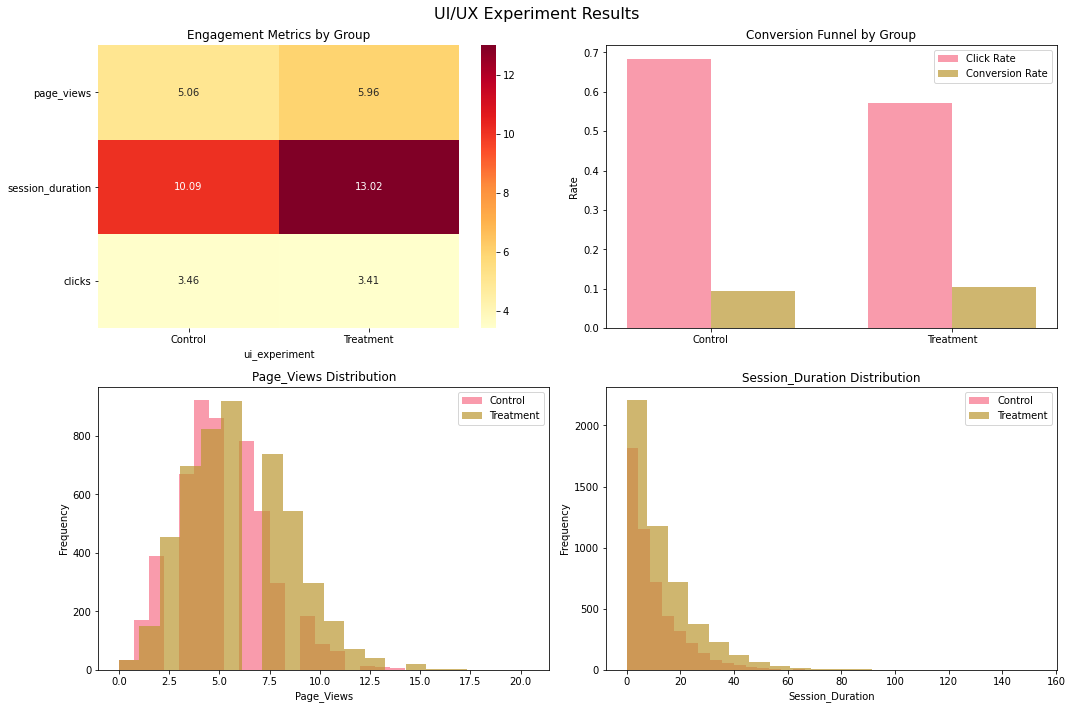

In [6]:
print("\n" + "="*80)
print("UI/UX EXPERIMENT ANALYSIS")
print("="*80)

ui_results = analyzer.run_experiment_analysis('ui_experiment', all_metrics)
print_experiment_results(ui_results, "UI/UX Experiment")

# Visualize UI experiment results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('UI/UX Experiment Results', fontsize=16)

# Engagement metrics heatmap
engagement_by_group = df.groupby('ui_experiment')[['page_views', 'session_duration', 'clicks']].mean()
sns.heatmap(engagement_by_group.T, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0,0])
axes[0,0].set_title('Engagement Metrics by Group')

# Conversion funnel
conversion_funnel = df.groupby('ui_experiment').agg({
    'page_views': 'sum',
    'clicks': 'sum',
    'converted': 'sum'
}).reset_index()

conversion_funnel['click_rate'] = conversion_funnel['clicks'] / conversion_funnel['page_views']
conversion_funnel['conversion_rate'] = conversion_funnel['converted'] / conversion_funnel['clicks']

x = np.arange(len(conversion_funnel))
width = 0.35

axes[0,1].bar(x - width/2, conversion_funnel['click_rate'], width, label='Click Rate', alpha=0.7)
axes[0,1].bar(x + width/2, conversion_funnel['conversion_rate'], width, label='Conversion Rate', alpha=0.7)
axes[0,1].set_title('Conversion Funnel by Group')
axes[0,1].set_ylabel('Rate')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(conversion_funnel['ui_experiment'])
axes[0,1].legend()

# Statistical significance visualization
metrics_to_plot = ['page_views', 'session_duration']
for i, metric in enumerate(metrics_to_plot):
    control_data = df[df['ui_experiment'] == 'Control'][metric]
    treatment_data = df[df['ui_experiment'] == 'Treatment'][metric]
    
    axes[1,i].hist(control_data, alpha=0.7, label='Control', bins=20)
    axes[1,i].hist(treatment_data, alpha=0.7, label='Treatment', bins=20)
    axes[1,i].set_title(f'{metric.title()} Distribution')
    axes[1,i].set_xlabel(metric.title())
    axes[1,i].set_ylabel('Frequency')
    axes[1,i].legend()

plt.tight_layout()
plt.show()

### 6. FEATURE EXPERIMENT ANALYSIS

In [7]:
print("\n" + "="*80)
print("FEATURE EXPERIMENT ANALYSIS")
print("="*80)

feature_results = analyzer.run_experiment_analysis('feature_experiment', all_metrics)
print_experiment_results(feature_results, "Feature Experiment")


FEATURE EXPERIMENT ANALYSIS

📊 FEATURE EXPERIMENT RESULTS:
------------------------------------------------------------

🎯 PAGE_VIEWS:
   Control Mean: 5.43
   Treatment Mean: 5.56
   Lift: 2.35%
   P-value: 0.0247
   Significant: ✅ YES
   Sample Sizes: Control=3822, Treatment=6172
   Effect Size: 0.051 (Small)

🎯 SESSION_DURATION:
   Control Mean: 11.46
   Treatment Mean: 11.60
   Lift: 1.22%
   P-value: 0.8327
   Significant: ❌ NO
   Sample Sizes: Control=3822, Treatment=6172
   Effect Size: 0.012 (Small)

🎯 CLICKS:
   Control Mean: 2.95
   Treatment Mean: 3.73
   Lift: 26.22%
   P-value: 0.0000
   Significant: ✅ YES
   Sample Sizes: Control=3822, Treatment=6172
   Effect Size: 0.390 (Small)

🎯 CONVERTED:
   Control Rate: 0.330 (33.0%)
   Treatment Rate: 0.354 (35.4%)
   Lift: 6.98%
   P-value: 0.0194
   Significant: ✅ YES
   Sample Sizes: Control=3822, Treatment=6172


### 7. MULTI-VARIATE ANALYSIS

In [8]:
print("\n" + "="*80)
print("MULTI-VARIATE EXPERIMENT ANALYSIS")
print("="*80)

# Analyze interaction effects between experiments
interaction_analysis = df.groupby(['pricing_experiment', 'ui_experiment', 'feature_experiment']).agg({
    'converted': 'mean',
    'page_views': 'mean',
    'session_duration': 'mean',
    'clicks': 'mean'
}).reset_index()

print("\nInteraction Effects Analysis:")
print("Top 3 performing combinations:")
top_combinations = interaction_analysis.nlargest(3, 'converted')
for idx, row in top_combinations.iterrows():
    print(f"   {row['pricing_experiment']}-{row['ui_experiment']}-{row['feature_experiment']}: "
          f"{row['converted']:.3f} conversion rate")

# Visualize interaction effects
fig = px.parallel_coordinates(
    interaction_analysis,
    dimensions=['pricing_experiment', 'ui_experiment', 'feature_experiment'],
    color='converted',
    color_continuous_scale='Viridis',
    title='Multi-variate Experiment Interaction Effects'
)
fig.show()



MULTI-VARIATE EXPERIMENT ANALYSIS

Interaction Effects Analysis:
Top 3 performing combinations:
   Treatment-Control-Treatment: 0.389 conversion rate
   Treatment-Control-Control: 0.384 conversion rate
   Treatment-Treatment-Treatment: 0.378 conversion rate


### 8. STATISTICAL POWER ANALYSIS

In [9]:
def calculate_sample_size(baseline_rate, minimum_detectable_effect, alpha=0.05, power=0.8):
    """Calculate required sample size for A/B test"""
    
    from scipy.stats import norm
    
    # Effect size
    p1 = baseline_rate
    p2 = p1 * (1 + minimum_detectable_effect)
    
    # Pooled probability
    p_pool = (p1 + p2) / 2
    
    # Calculate sample size
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    
    n = (z_alpha * np.sqrt(2 * p_pool * (1 - p_pool)) + 
         z_beta * np.sqrt(p1 * (1 - p1) + p2 * (1 - p2)))**2 / (p2 - p1)**2
    
    return int(np.ceil(n))

print("\n" + "="*80)
print("STATISTICAL POWER ANALYSIS")
print("="*80)

# Calculate power for current experiments
baseline_conversion = df[df['pricing_experiment'] == 'Control']['converted'].mean()
current_sample_size = len(df[df['pricing_experiment'] == 'Control'])

print(f"\nCurrent baseline conversion rate: {baseline_conversion:.3f}")
print(f"Current sample size per group: {current_sample_size}")

print("\nRequired sample sizes for different effect sizes:")
for effect_size in [0.05, 0.10, 0.15, 0.20]:
    required_n = calculate_sample_size(baseline_conversion, effect_size)
    print(f"   {effect_size*100:.0f}% lift: {required_n:,} samples per group")


STATISTICAL POWER ANALYSIS

Current baseline conversion rate: 0.316
Current sample size per group: 5130

Required sample sizes for different effect sizes:
   5% lift: 13,796 samples per group
   10% lift: 3,491 samples per group
   15% lift: 1,570 samples per group
   20% lift: 892 samples per group


### 9. EXPERIMENT MONITORING DASHBOARD

In [10]:
def create_experiment_dashboard(df, experiment_col):
    """Create monitoring dashboard for experiment"""
    
    # Calculate key metrics over time
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        daily_metrics = df.groupby([df['date'].dt.date, experiment_col]).agg({
            'converted': 'mean',
            'page_views': 'mean',
            'session_duration': 'mean'
        }).reset_index()
        
        # Create time series plot
        fig = make_subplots(
            rows=3, cols=1,
            subplot_titles=['Conversion Rate', 'Page Views', 'Session Duration'],
            vertical_spacing=0.1
        )
        
        for group in ['Control', 'Treatment']:
            group_data = daily_metrics[daily_metrics[experiment_col] == group]
            
            fig.add_trace(
                go.Scatter(x=group_data['date'], y=group_data['converted'],
                          mode='lines+markers', name=f'{group} - Conversion'),
                row=1, col=1
            )
            
            fig.add_trace(
                go.Scatter(x=group_data['date'], y=group_data['page_views'],
                          mode='lines+markers', name=f'{group} - Page Views'),
                row=2, col=1
            )
            
            fig.add_trace(
                go.Scatter(x=group_data['date'], y=group_data['session_duration'],
                          mode='lines+markers', name=f'{group} - Session Duration'),
                row=3, col=1
            )
        
        fig.update_layout(height=800, title_text=f"{experiment_col} Monitoring Dashboard")
        return fig
    
    return None

# Create dashboard for pricing experiment
if 'date' in df.columns:
    dashboard = create_experiment_dashboard(df, 'pricing_experiment')
    if dashboard:
        dashboard.show()

### 10. EXPERIMENT RECOMMENDATIONS

In [11]:
def generate_experiment_recommendations(results):
    """Generate actionable recommendations based on experiment results"""
    
    recommendations = []
    
    for experiment, metrics in results.items():
        experiment_name = experiment.replace('_', ' ').title()
        
        # Check overall performance
        significant_wins = sum(1 for m in metrics.values() if m['significant'] and m['lift'] > 0)
        total_metrics = len(metrics)
        
        if significant_wins >= total_metrics * 0.5:
            recommendations.append(f"🚀 {experiment_name}: IMPLEMENT - Shows significant positive impact")
        elif significant_wins > 0:
            recommendations.append(f"🤔 {experiment_name}: INVESTIGATE - Mixed results, needs deeper analysis")
        else:
            recommendations.append(f"❌ {experiment_name}: HALT - No significant positive impact")
        
        # Specific metric recommendations
        for metric, result in metrics.items():
            if result['significant'] and result['lift'] > 10:
                recommendations.append(f"   💡 {metric.title()} shows strong {result['lift']:.1f}% improvement")
            elif result['significant'] and result['lift'] < -5:
                recommendations.append(f"   ⚠️ {metric.title()} shows concerning {result['lift']:.1f}% decrease")
    
    return recommendations

print("\n" + "="*80)
print("EXPERIMENT RECOMMENDATIONS")
print("="*80)

recommendations = generate_experiment_recommendations(analyzer.results)
for rec in recommendations:
    print(rec)


EXPERIMENT RECOMMENDATIONS
🤔 Pricing Experiment: INVESTIGATE - Mixed results, needs deeper analysis
   💡 Converted shows strong 19.0% improvement
🚀 Ui Experiment: IMPLEMENT - Shows significant positive impact
   💡 Page_Views shows strong 17.9% improvement
   💡 Session_Duration shows strong 29.0% improvement
🚀 Feature Experiment: IMPLEMENT - Shows significant positive impact
   💡 Clicks shows strong 26.2% improvement


### 11. EXPERIMENT SUMMARY REPORT

In [12]:

print("\n" + "="*80)
print("EXPERIMENT SUMMARY REPORT")
print("="*80)

# Create summary table
summary_data = []
for experiment, metrics in analyzer.results.items():
    for metric, result in metrics.items():
        summary_data.append({
            'Experiment': experiment.replace('_', ' ').title(),
            'Metric': metric.title(),
            'Control': f"{result.get('control_mean', result.get('control_rate', 0)):.3f}",
            'Treatment': f"{result.get('treatment_mean', result.get('treatment_rate', 0)):.3f}",
            'Lift (%)': f"{result['lift']:.1f}%",
            'P-value': f"{result['p_value']:.4f}",
            'Significant': '✅' if result['significant'] else '❌'
        })

summary_df = pd.DataFrame(summary_data)
print("\nEXPERIMENT RESULTS SUMMARY:")
print(summary_df.to_string(index=False))

# Calculate experiment success rate
total_tests = len(summary_df)
successful_tests = sum(summary_df['Significant'] == '✅')
success_rate = (successful_tests / total_tests) * 100

print(f"\n📊 OVERALL EXPERIMENT PERFORMANCE:")
print(f"   • Total Tests Run: {total_tests}")
print(f"   • Successful Tests: {successful_tests}")
print(f"   • Success Rate: {success_rate:.1f}%")

# Risk assessment
print(f"\n⚠️ RISK ASSESSMENT:")
negative_lifts = sum(1 for _, row in summary_df.iterrows() if float(row['Lift (%)'].strip('%')) < 0)
if negative_lifts > 0:
    print(f"   • {negative_lifts} metrics show negative impact")
    print("   • Consider rollback if core metrics are affected")
else:
    print("   • No negative impacts detected")
    print("   • Safe to proceed with implementation")

print("\n" + "="*80)
print("EXPERIMENT ANALYSIS COMPLETE!")
print("="*80)
print("Use these insights to make data-driven product decisions.")
print("Remember to validate results with additional testing before full rollout.")
print("="*80)


EXPERIMENT SUMMARY REPORT

EXPERIMENT RESULTS SUMMARY:
        Experiment           Metric Control Treatment Lift (%) P-value Significant
Pricing Experiment       Page_Views   5.498     5.515     0.3%  0.7928           ❌
Pricing Experiment Session_Duration  11.564    11.522    -0.4%  0.5901           ❌
Pricing Experiment           Clicks   3.478     3.386    -2.6%  0.0500           ❌
Pricing Experiment        Converted   0.316     0.375    19.0%  0.0000           ✅
     Ui Experiment       Page_Views   5.057     5.963    17.9%  0.0000           ✅
     Ui Experiment Session_Duration  10.093    13.017    29.0%  0.0000           ✅
     Ui Experiment           Clicks   3.459     3.408    -1.5%  0.0963           ❌
     Ui Experiment        Converted   0.329     0.361     9.5%  0.0011           ✅
Feature Experiment       Page_Views   5.428     5.555     2.4%  0.0247           ✅
Feature Experiment Session_Duration  11.457    11.597     1.2%  0.8327           ❌
Feature Experiment           Cl